In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import json

In [ ]:
edu = r"/Users/phamthiphuongthuy/Desktop/Unimelb/Y2S1/EODP/eodp_a2/A2 datasets/journey_to_education_vista_2023_2024.csv"
work = r"/Users/phamthiphuongthuy/Desktop/Unimelb/Y2S1/EODP/eodp_a2/A2 datasets/journey_to_work_vista_2023_2024.csv"

In [3]:
data = pd.read_csv(edu)
df = pd.DataFrame(data)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/phamthiphuongthuy/Desktop/Unimelb/Y2S1/EODP/A1_EODP/journey_to_education_vista_2023_2024.csv'

In [ ]:
df['wasted_time'] = df['journey_elapsed_time'] - df['journey_travel_time']
df.describe()

,start_time,end_time,startime_01,startime_02,startime_03,startime_04,startime_05,startime_06,startime_07,startime_08,...,travtime_11,travtime_12,travtime_13,travtime_14,travtime_15,journey_travel_time,journey_distance,journey_elapsed_time,journey_weight,wasted_time
count,1819.000000,1819.000000,1819.000000,580.000000,317.000000,111.000000,74.000000,14.0000,4.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,517.002749,553.549753,517.002749,526.853448,540.485804,547.441441,558.472973,606.5000,596.500000,830.0,...,1.0,20.0,3.0,7.0,4.0,31.915888,18.940751,36.547004,744.884328,4.631116
std,184.947578,183.770047,184.947578,145.280365,129.012574,132.104276,123.899122,117.9555,144.047446,NaN,...,NaN,NaN,NaN,NaN,NaN,22.319292,19.808163,34.065868,626.229352,21.726086
min,240.000000,264.000000,240.000000,280.000000,290.000000,318.000000,374.000000,486.0000,499.000000,830.0,...,1.0,20.0,3.0,7.0,4.0,1.000000,-2.000000,1.000000,34.210893,0.000000
25%,414.500000,450.000000,414.500000,455.000000,475.000000,475.500000,487.750000,538.2500,505.750000,830.0,...,1.0,20.0,3.0,7.0,4.0,15.000000,6.370945,15.000000,368.931874,0.000000
50%,479.000000,513.000000,479.000000,495.000000,513.000000,524.000000,531.500000,578.0000,540.000000,830.0,...,1.0,20.0,3.0,7.0,4.0,30.000000,13.854280,30.000000,575.020550,0.000000
75%,540.000000,580.500000,540.000000,540.000000,555.000000,592.500000,582.000000,650.7500,630.750000,830.0,...,1.0,20.0,3.0,7.0,4.0,44.000000,25.634805,47.000000,924.450442,2.000000
max,1557.000000,1570.000000,1557.000000,1272.000000,1118.000000,956.000000,950.000000,913.0000,807.000000,830.0,...,1.0,20.0,3.0,7.0,4.0,190.000000,250.513210,495.000000,7093.417662,430.000000


In [ ]:
bins = [0, 1, 5, 10, 30, float('inf')]
waste_time_labels = ['0', '1-5', '5-10','10-30', '30+']
df['group_wasted_time'] = pd.cut(df['wasted_time'], bins=bins, labels=waste_time_labels, right=False)

In [ ]:
# Count number of stops from destpurp1_desc_01 to _15
stop_labels = ['0 stop', '1 stop', '2 stops', '3+ stops']
stop_cols = [f'destpurp1_desc_{str(i).zfill(2)}' for i in range(1, 16)]
df['num_stops'] = df[stop_cols].notna().sum(axis=1) - 1  # Subtract 1 because destination is not a stop
df['stop_category'] = df['num_stops'].apply(
    lambda x: f'{int(x)} stop' if x in [0, 1] else ('2 stops' if x == 2 else '3+ stops')
)

print("Stop categories distribution:")
print(df['stop_category'].value_counts())

Stop categories distribution:
stop_category
0 stop      1239
1 stop       263
2 stops      206
3+ stops     111
Name: count, dtype: int64


In [ ]:
print(df["main_journey_mode"].unique())

['Vehicle Driver' 'Vehicle Passenger' 'Train' 'Public Bus' 'Walking'
 'Motorcycle' 'Tram' 'Bicycle' 'Taxi / Rideshare' 'School Bus']


In [ ]:
def categorize_mode(mode):
    if mode in ['Train', 'Public Bus', 'Tram', 'School Bus']:
        return 'Public'
    elif mode in ['Vehicle Driver', 'Vehicle Passenger', 'Motorcycle', 'Taxi / Rideshare']:
        return 'Private'
    elif mode in ['Walking', 'Bicycle']:
        return 'Active'
    else:
        return 'Other'
    
df['transport_category'] = df['main_journey_mode'].apply(categorize_mode)
filtered_df = df.dropna(subset=['group_wasted_time', 'transport_category', 'stop_category'])

print("Transport category distribution:")
print(df['transport_category'].value_counts())

Transport category distribution:
transport_category
Private    1466
Public      259
Active       94
Name: count, dtype: int64


In [ ]:
plot_data = (
    filtered_df.groupby(['group_wasted_time', 'transport_category', 'stop_category'],observed=True)['journey_weight']
    .sum()
    .reset_index()
)
plot_data['total'] = plot_data.groupby(['transport_category', 'stop_category'])['journey_weight'].transform('sum')
plot_data['proportion'] = plot_data['journey_weight'] / plot_data['total']


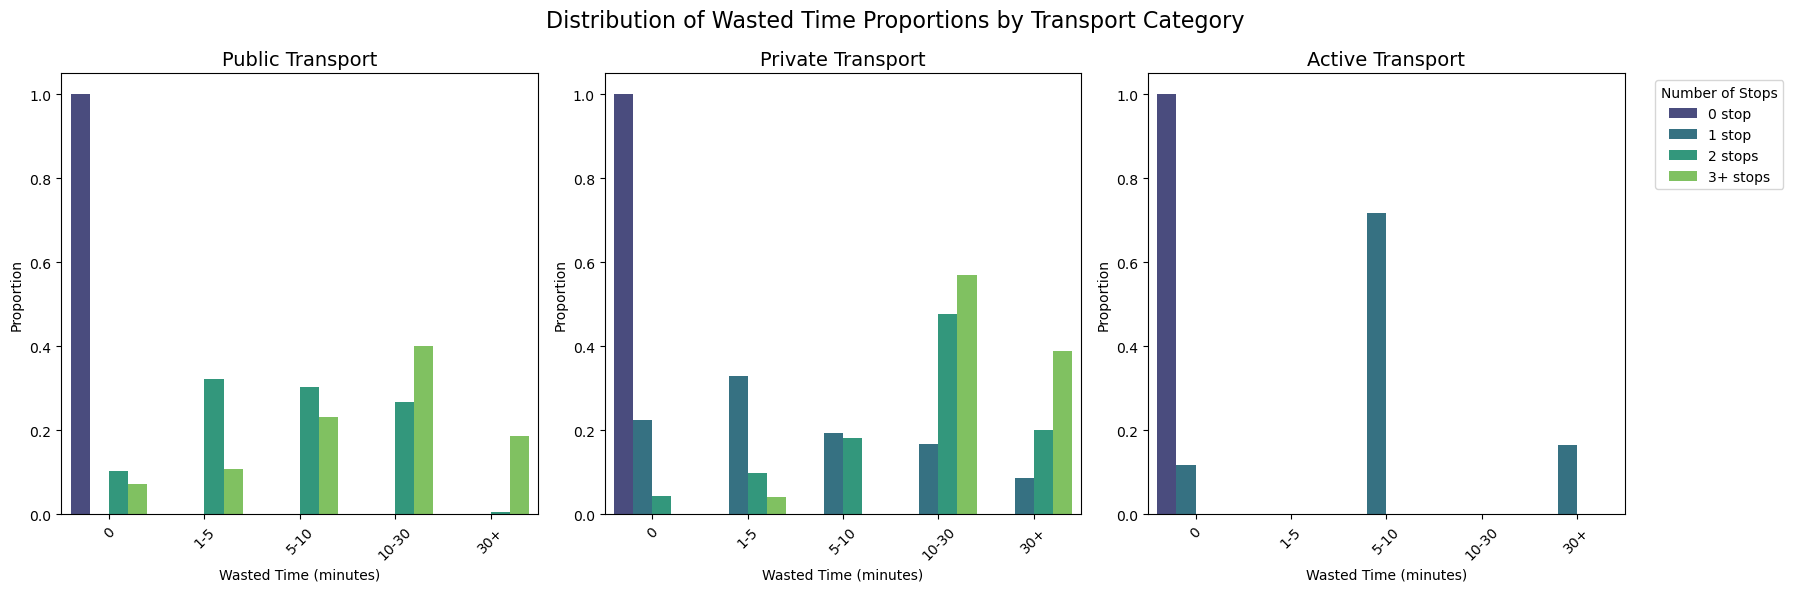

In [ ]:
# Create 3 separate graphs for each transport category
# Each bar represents proportion, color represents number of stops

transport_categories = ['Public', 'Private', 'Active']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Wasted Time Proportions by Transport Category', fontsize=16)

for i, transport_cat in enumerate(transport_categories):
    # Filter data for this transport category
    subset_data = plot_data[plot_data['transport_category'] == transport_cat]
    
    # Create the plot
    sns.barplot(data=subset_data, 
                x='group_wasted_time', 
                y='proportion',
                hue='stop_category',
                hue_order=stop_labels,
                palette='viridis',
                ax=axes[i],
                order=waste_time_labels)
    
    # Customize each subplot
    axes[i].set_title(f'{transport_cat} Transport', fontsize=14)
    axes[i].set_xlabel('Wasted Time (minutes)')
    axes[i].set_ylabel('Proportion')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Only show legend for the last subplot
    if i < 2:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(title='Number of Stops', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('task3_1.png', dpi=300, bbox_inches='tight')
plt.show()

3.2

In [ ]:
bins = [0, 10, 20, 40, float('inf')]
dist_labels = ['0-10', '10-20', '20-40', '40+']
df['group_travel_distance'] = pd.cut(df['journey_distance'], bins=bins, labels=dist_labels, right=False)
df['group_travel_distance'].value_counts()

group_travel_distance
0-10     693
10-20    492
20-40    445
40+      180
Name: count, dtype: int64

In [ ]:
percentage = {}
# Count combinations of wasted time and distance groups
dist_and_wasted_time = (
    df[['group_wasted_time','group_travel_distance']]
    .value_counts()
    .rename('count')         # turn Series values into a column name
    .reset_index()           # make the index regular columns
)

In [ ]:
dist_and_wasted_time

,group_wasted_time,group_travel_distance,count
0,0,0-10,574
1,0,10-20,342
2,0,20-40,276
3,0,40+,119
4,10-30,20-40,55
5,1-5,0-10,53
6,5-10,10-20,50
7,1-5,20-40,48
8,10-30,10-20,44
9,5-10,20-40,44


In [ ]:
dist_and_wasted_time['percentage'] = (
    dist_and_wasted_time.groupby("group_travel_distance", observed=False)["count"]
    .transform(lambda x: 100 * x / x.sum())
    )

In [ ]:
result = {}
for dist_group in dist_labels:
    subset = dist_and_wasted_time[dist_and_wasted_time['group_travel_distance'].eq(dist_group)]
    result[dist_group] = {
        row['group_wasted_time']: {
            'count': int(row['count']),
            'percentage': round(row['percentage'], 2)
        }
        for _, row in subset.iterrows()
    }


In [ ]:
# Save results to JSON file
with open('task3_2.json', 'w') as f:
    json.dump(result, f, indent=4)

['0-10', '10-20', '20-40', '40+']


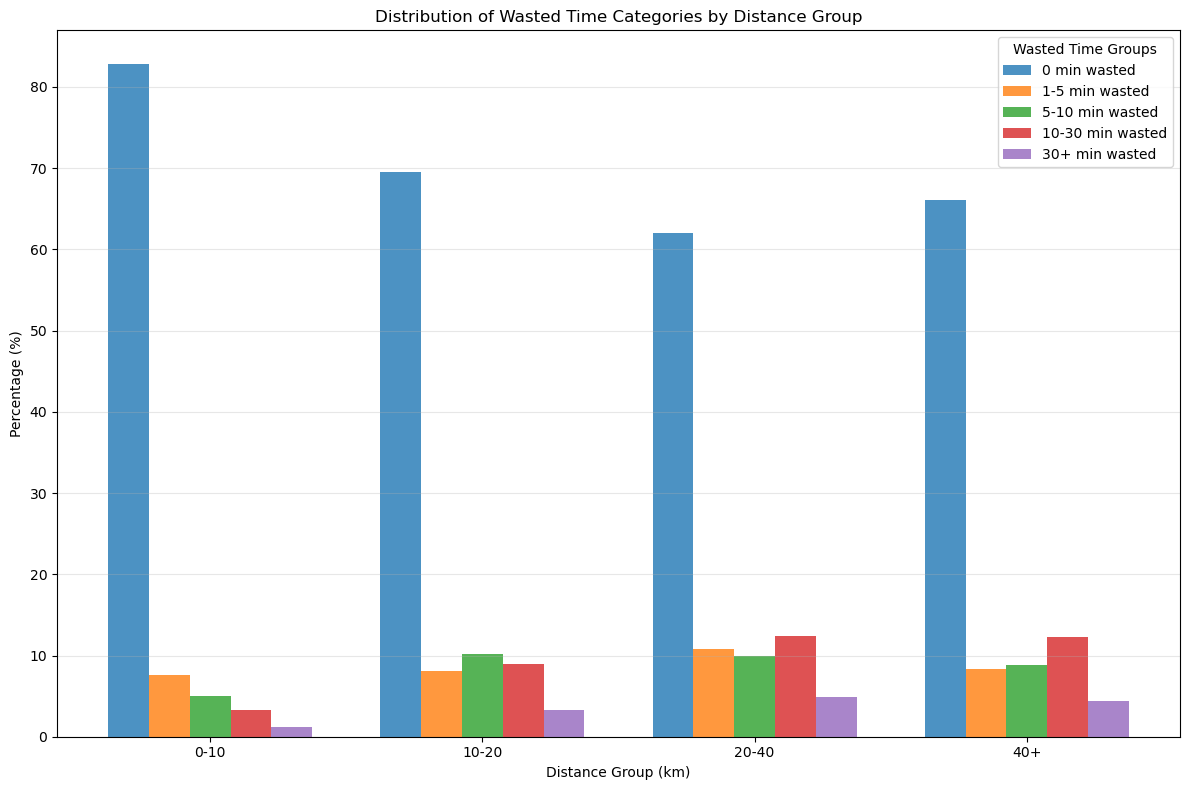

In [ ]:
# Load the JSON data
with open('task3_2.json', 'r') as f:
    data = json.load(f)

# Prepare data for plotting
distance_groups = list(data.keys())
print(distance_groups)
wasted_time_categories = ['0', '1-5', '5-10', '10-30', '30+']

# Set up the plot
plt.figure(figsize=(12, 8))
x = np.arange(len(distance_groups))
width = 0.15  # Width of bars

# Create bars for each wasted time category
for i, category in enumerate(wasted_time_categories):
    percentages = []
    for dist_group in distance_groups:
        if category in data[dist_group]:
            percentages.append(data[dist_group][category]['percentage'])
        else:
            percentages.append(0)
    
    plt.bar(x + i * width, percentages, width, label=f'{category} min wasted', alpha=0.8)

# Customize the plot
plt.xlabel('Distance Group (km)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Wasted Time Categories by Distance Group')
plt.xticks(x + width * 2, distance_groups)
plt.legend(title='Wasted Time Groups')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('task3_2.png', dpi=300, bbox_inches='tight')
plt.show()